In [1]:
from agents import agent_loss, sampled_agent_reward, CAPM_Agent, MVP_Agent, Uniform_Agent
from trading_env.environment import TradingEnv

import dill
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt

## Recall data

In [2]:
with open('test_data.dill','rb') as dill_file:
    test_dataset = dill.load(dill_file)
test_dates = test_dataset['dates']
test_data = test_dataset['data']
test_symbols = test_dataset['symbols']

n_stocks = test_data.shape[0]

env = TradingEnv(test_data)
start = env._start_tick

In [3]:
shape = test_data.shape
print(f'The dataset consists of {shape[0]} stocks, with {shape[2]} features, over {shape[1]} trading days.')
print(f'The symbols are: {test_symbols}')

The dataset consists of 64 stocks, with 4 features, over 253 trading days.
The symbols are: ['AAPL', 'AZO', 'CMI', 'BLL', 'TJX', 'UNH', 'SHW', 'OXY', 'YUM', 'UNP', 'APA', 'PCAR', 'VFC', 'NKE', 'GWW', 'LIN', 'ADSK', 'MRO', 'LMT', 'DE', 'CSX', 'ECL', 'CAT', 'PGR', 'PHM', 'COP', 'NEE', 'HSY', 'NUE', 'BDX', 'NSC', 'SO', 'T', 'GPS', 'IP', 'CMA', 'UNM', 'LNC', 'MAS', 'BK', 'TXT', 'SEE', 'MRK', 'SCHW', 'BMY', 'HIG', 'BAC', 'INTC', 'AVY', 'BSX', 'MSFT', 'F', 'BBY', 'KEY', 'RF', 'CSCO', 'AMAT', 'AES', 'HPQ', 'IPG', 'HWM', 'MU', 'C', 'AIG']


## Recall trained agent

In [4]:
with open('dpm_agent_trained.dill','rb') as dill_file:
    dpm_agent = dill.load(dill_file)

capm_agent = CAPM_Agent()
mvp_agent = MVP_Agent()
uniform_agent = Uniform_Agent()

### Run a single simulation on all stock data

In [5]:
env = TradingEnv(test_data)

dpm_loss = agent_loss(env,dpm_agent)
dpm_val_hist = env.portfolio_value_hist

capm_loss = agent_loss(env,capm_agent)
capm_val_hist = env.portfolio_value_hist

mvp_loss = agent_loss(env,mvp_agent)
mvp_val_hist = env.portfolio_value_hist

uniform_loss = agent_loss(env,uniform_agent)
uniform_val_hist = env.portfolio_value_hist


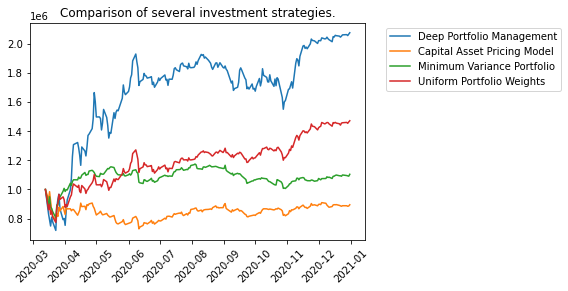

In [6]:
plt.plot(test_dates[start:],dpm_val_hist,label='Deep Portfolio Management')
plt.plot(test_dates[start:],capm_val_hist,label='Capital Asset Pricing Model')
plt.plot(test_dates[start:],mvp_val_hist,label='Minimum Variance Portfolio')
plt.plot(test_dates[start:],uniform_val_hist,label='Uniform Portfolio Weights')
plt.xticks(rotation=45)
plt.legend(loc='upper right',bbox_to_anchor=(1.6, 1) )
plt.title('Comparison of several investment strategies.')
plt.show()

## Statistical analysis

One simulation is interesting to view but it is important to compare the statistical performance of the agents. Here we will simulate several trials and perform a simple t-test on the results to compare agents. Note the randomization is in the subset of stocks chosen in each trial. On each trial we select with replacement a configuration of 10 out of 36 stocks on which to run simulations. There is a total of ${36 \choose 10} \approx 9.1 \times 10^{9}$ possible configurations. On each trial the configuration is fed into each agent, thus yielding a paired t-test experiment design.

In [7]:
TRIALS = 100
n_group_size = 8

capm_agent = CAPM_Agent()
mvp_agent = MVP_Agent()
uniform_agent = Uniform_Agent()
agents = [dpm_agent,
            capm_agent,
            mvp_agent,
            uniform_agent]

rewards = sampled_agent_reward(TradingEnv,test_data,agents,n_group_size,TRIALS)     

rewards_df = pd.DataFrame(rewards).astype(float)

In [8]:
print(f'The rewards_df dataframe contains {rewards_df.shape[0]} rows ',end='') 
print('representing normalized annual returns for each agent for each ', end = '')
print('selected configuration.' )
rewards_df.head()

The rewards_df dataframe contains 100 rows representing normalized annual returns for each agent for each selected configuration.


,DPM_Agent,CAPM_Agent,MVP_Agent,Uniform_Agent
0,0.203576,0.215971,0.162217,0.437676
1,0.547753,-0.435364,0.308617,0.421100
2,0.817841,0.194762,0.453053,0.553807
3,0.346089,0.010221,0.162640,0.396499
4,0.553004,0.073414,0.036239,0.470011


## Visualize the results

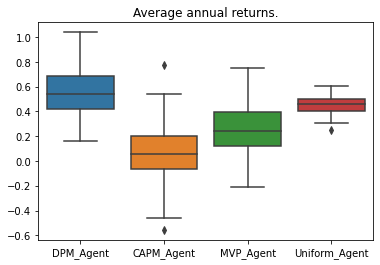

In [9]:
#final_vals_df = pd.DataFrame(final_vals).astype(float)

sns.boxplot(data=rewards_df)
plt.title('Average annual returns.')
plt.show()


In [10]:
print('Mean annual returns for each agent.')
rewards_df.mean()

Mean annual returns for each agent.


DPM_Agent        0.566477
CAPM_Agent       0.072913
MVP_Agent        0.258045
Uniform_Agent    0.452028
dtype: float64

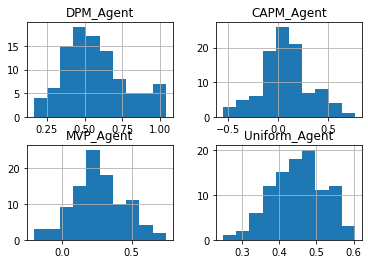

In [11]:
rewards_df.hist()
plt.show()

## t-test

It seems from the above visualizations that the DeepPortfolio agent outperforms the Uniform agent, but can we be sure about that?

We perform a t-tests with the alternative hypotheses that DeepPortfolio outperforms the Uniform portfolio.

In [12]:
stats.ttest_rel(rewards_df['DPM_Agent'],rewards_df['Uniform_Agent'] ,alternative = 'greater')

Ttest_relResult(statistic=6.113219827777773, pvalue=9.715803379650924e-09)

The p value is very small, so we can easily reject the null hypothesis and conclude DeepPortfolio outperforms the Uniform agent.
 
